# BT2101 Introduction to Logistic Regression

#### Version: Python 3

## 1 Goal:

In this notebook, we will explore logistic regression using:
* Gradient ascent method (because you cannot get closed-form solutions)
* Open-source package: `scikit-learn`

For the gradient descent method, you will:
* Use numpy to write functions
* Write a likelihood function
* Write a derivative function
* Write an output function
* Write a gradient ascent function
* Add a constant column of 1's as intercept term
* Use the gradient ascent function to get regression estimators

In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from __future__ import division
%matplotlib inline

### 1.1 Summary of Logistic Regression

From the lecture class, we know that a typical logistic regression model of *N* observations and *p* predictors:

\begin{align}
\text{Logit}(P(y_{i}=1)) &= log(\frac{P(y_{i}=1)}{1-P(y_{i}=1)}) \\
& = \beta_0 + \sum_{j=1}^p x_j \beta_j \\
& = X\beta
\end{align}

Rewrite the model and we can get this function:

$$ P(y_{i}=1) = \frac{e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}{1+e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}} $$


We aim to **Maximize** the (log-)likelihood function:

$$ l(\beta) = \prod_{i=1}^{N}[\frac{e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}{1+e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}]^{y_i}[\frac{1}{1+e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}]^{(1-y_i)} $$
Or
$$ ll(\beta) = \sum_{i=1}^{N}[-log(1+e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j})+y_{i}(\beta_{0}+\sum_{j=1}^{p}x_j\beta_j)] $$

Let us **Maximize** the log-likelihood function $ll(\beta)$ and get derivative with respect to $\beta_j$:

\begin{align*}
\frac{\partial ll(\beta)}{\partial\beta_j} & = -\sum_{i=1}^{N}\frac{e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}{1+e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}x_{ij}+\sum_{i=1}^{N}y_{i}x_{ij} \\
& = \sum_{i=1}^{N}(y_{i}-\frac{e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}{1+e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}})x_{ij} \\
& = \sum_{i=1}^{N}(y_{i}-P(y_{i}=1))x_{ij} \\
\end{align*}

Remember that the predicted score $P(y_{i}=1)$ is calculated as $\frac{e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}{1+e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j}}=\frac{1}{1+e^{-(\beta_{0}+\sum_{j=1}^{p}x_{j}\beta_{j})}}$ <br/>

Then we can write a predicted score function first.

In [2]:
def score(feature_matrix, weight_vector):
    '''This function is used to calculate predicted probability or score.
    
    Inputs:
    1) feature_matrix: A matrix of selected features;
    2) weight_vector: A vector of coefficients for selected features;
    
    Outputs:
    1) score: A vector of predicted probabilities or scores   
    
    '''
    
    score = 1/(1+np.exp(-np.dot(feature_matrix, weight_vector)))

    return score

In [3]:
# Let us have a test
features = np.array([[2.0, 1.5], [4.8, 5.2]])
weights = np.array([1.0, 1.0])
weights = np.ones((2, 1))
score(features, weights)

array([[0.97068777],
       [0.9999546 ]])

## 2 Gradient Ascent
### 2.1 Computing Derivatives

How can we compute the derivatives of the log-likelihood function? <br/>

We already know that the derivative with respect to $\beta_j$ is: <br/>
\begin{align*}
\frac{\partial ll(\beta)}{\partial\beta_j} & = \sum_{i=1}^{N}(y_{i}-P(y_{i}=1))x_{ij} \\
\end{align*}

In [4]:
def derivative(feature_matrix, error_vector):
    '''This function is used to calculate the derivatives for features.
    Inputs:
    1) feature_matrix: Data matrix of features (j = 0,...,p)
    2) error_vector: A vector of errors of N observations    
    
    Outputs:
    1) derive: Derivative for this feature j    
    
    '''
    
    derive = np.dot(feature_matrix.T, error_vector)
    
    return derive

In [5]:
# Let us have a test
features = np.array([[2.0], [4.8]])
weights = np.ones((1, 1))
true_outputs = np.array([[1], [0]])
predict_score = score(features, weights)
errors = true_outputs - predict_score

print ("True output is: ")
print (true_outputs)
print ("Predicted score is: ")
print (predict_score)
print ("Error is: ")
print (errors)
print ("Derivative is: ")
print (derivative(features, errors))

True output is: 
[[1]
 [0]]
Predicted score is: 
[[0.88079708]
 [0.99183743]]
Error is: 
[[ 0.11920292]
 [-0.99183743]]
Derivative is: 
[[-4.52241381]]


### 2.2 Computing Log-likehood

In the lecture class, we know the log likelihood function is computed as:

\begin{align*}
ll(\beta) & = \sum_{i=1}^{N}[-log(1+e^{\beta_0 + \sum_{j=1}^{p}x_j\beta_j})+y_{i}(\beta_{0}+\sum_{j=1}^{p}x_j\beta_j)] \\
\end{align*}

In [6]:
def log_likelihood(feature_matrix, weight_vector, output_vector):
    '''This function is used to calculate log-likelihood value of given features, output and coefficients
    Inputs:
    1) feature_matrix: A matrix of selected features
    2) weight_vector: A vector of coefficients
    3) output_vector: A vector of true outputs
    
    Outputs:
    1) ll: Log-likelihood value
    
    '''
    
    # Linear term: Xbeta
    X_beta = np.dot(feature_matrix, weight_vector)
    
    # Sum term: The term in the sum_up bracket
    sum_term = -np.log(1+np.exp(X_beta)) + output_vector*X_beta
    
    # Get log-likelihood
    ll = np.sum(sum_term)    
    
    return ll       
    

### 2.3 Procedures for Gradient Ascent

Step 0: Initialize $ \beta = (\beta_{0},\dots,\beta_{p}) $; <br/>
Step 1: Calculate $ \beta_{j} \leftarrow \beta_{j} + Stepsize\times(\sum_{i=1}^{N}(y_{i}-P(y_{i}=1))x_{ij}) $, for j = 1,...,p; <br/>
Step 2: If not converged, go back to Step 1; <br/>
Step 3: Get $ \beta $.

In [7]:
def Logistic_GA(initial_weights, feature_matrix, true_output, step_size, tolerance, n_iter):
    '''This function is used to iteratively calculate coefficients for logistic regression model using Gradient Aescent.
    Inputs:
    1) initial_weights: Initial regression coefficients
    2) feature_matrix: A matrix of selected features
    3) true_output: A vector of true outputs -> [0, 1]
    4) step_size: Size of step for each iteration of gradient search
    5) tolerance: Indicate converging condition
    6) n_iter: Maximum number of iterations
    
    Outputs:
    1) weights: Estimated coefficients.    
    
    '''
    
    weights = np.array(initial_weights, dtype=np.float64)
    
    for i in range(n_iter):
        # Calculate predicted scores, or probabilitis of 1's
        prediction = score(feature_matrix, weights)
        
        # Calculate errors
        error = true_output - prediction
        
        # Calculating derivatives for weights
        derivative_vector = derivative(feature_matrix, error) 
        
        # Updating weights
        weights += step_size * derivative_vector        
        
        # Converging conditions: L2 norm for derivatives
        sum_squared_gradient = np.sum(np.power(derivative_vector,2))
        
        # Verify whether converging early and Report Log-likelihood values            
        if np.sqrt(sum_squared_gradient) < tolerance: 
            # Calculate log-likelihood
            loglike = log_likelihood(feature_matrix, weights, true_output)
            
            # Print out log-likelihood
            print ('Iteration %10d: Log-likelihood = %.4f' % (i, loglike))
            
            return weights
        
        elif (i<=20) or (i<=100 and i%10==0) or (i<=1000 and i%100==0) or (i==n_iter):            
            # Calculate log-likelihood
            loglike = log_likelihood(feature_matrix, weights, true_output)
            
            # Print out log-likelihood
            print ('Iteration %10d: Log-likelihood = %.4f' % (i, loglike))
            
    
    return weights


## 3 Convert Pandas DataFrame to Numpy Array

We need to: <br/>
1. Convert Pandas DataFrame into a Numpy Array/Matrix to do internal calculations;
2. Augment this Array/Matrix by adding 1's column in the first column, in order to calculate the intercept.

In [8]:
def convert_data(df, feature_names, output_name):
    '''This function is used to convert pandas dataframe to numpy array/matrix, and augment it with 1's column as intercept.
    Inputs:
    1) df: Original data in the format of pandas dataframe
    2) feature_names: A list of names of selected features
    3) output_name: Name of selected outputs
    
    Outputs:
    1) feature_matrix: Augmented feature matrix
    2) output_vector: A vector of true outputs    
    
    '''    
    
    # Feature names of Augmented matrix 
    augment_feature_names = ['intercept'] + feature_names
    
    # Augmented feature matrix by adding constant 1's as intercept term, and reorder the feature matrix
    df['intercept'] = 1 
    feature_matrix = df[augment_feature_names]
    n, k = feature_matrix.shape # n: number of observations; k: number of weights
    
    # Convert selected feature matrix and output vector to Numpy Array
    feature_matrix = feature_matrix.values.reshape((n, k))
    output_vector = df[output_name].values.reshape((n, 1))

    return (feature_matrix, output_vector)

## 4 Load Dataset and Conduct Estimations

Our dataset can be obtained from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Iris).

### 4.1 Attribute Information:

Attribute Information:

1. sepal length in cm 
2. sepal width in cm 
3. petal length in cm 
4. petal width in cm 
5. class: <br/>
-- Iris Setosa <br/>
-- Iris Versicolour <br/>
-- Iris Virginica


### Suppose: 1:class='Iris-setosa'; 0:otherwise
### It means we want to predict whether class is 'Iris-setosa' (Y=1) or not (Y=0)

In [9]:
# Import dataset into Python Pandas DataFrame
filepath = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
colnames = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
data = pd.read_csv(filepath, header=None, names=colnames, dtype={'sepal_length':np.float64, 'sepal_width':np.float64, 'petal_length':np.float64, 'petal_width':np.float64})
data.head(n=5)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
data.dropna() # Drop null values
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [11]:
# Create an output dummy
data['Iris_setosa'] = data['class'].map(lambda x: 1 if x=='Iris-setosa' else 0)

In [12]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width,Iris_setosa
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,0.333333
std,0.828066,0.433594,1.764420,0.763161,0.472984
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,0.000000
75%,6.400000,3.300000,5.100000,1.800000,1.000000
max,7.900000,4.400000,6.900000,2.500000,1.000000


In [13]:
# Select features and output
feature_list =  ['sepal_width', 'petal_length']
output_label = 'Iris_setosa'

features = convert_data(data, feature_list, output_label)[0]
output = convert_data(data, feature_list, output_label)[1]

Now set up initial parameters and try gradient ascent:

In [14]:
# Set up
initial_weights = np.ones((len(feature_list)+1, 1))
step_size = 7e-5 
tolerance = 2e-9
iteration = 1000

In [15]:
# Try estimation with gradient descent
coefficients = Logistic_GA(initial_weights, features, output, step_size, tolerance, iteration)
print ('\nIntercept ','X1', 'X2')
coefficients

Iteration          0: Log-likelihood = -854.7068
Iteration          1: Log-likelihood = -831.4416
Iteration          2: Log-likelihood = -808.1852
Iteration          3: Log-likelihood = -784.9390
Iteration          4: Log-likelihood = -761.7047
Iteration          5: Log-likelihood = -738.4844
Iteration          6: Log-likelihood = -715.2805
Iteration          7: Log-likelihood = -692.0960
Iteration          8: Log-likelihood = -668.9344
Iteration          9: Log-likelihood = -645.7998
Iteration         10: Log-likelihood = -622.6974
Iteration         11: Log-likelihood = -599.6331
Iteration         12: Log-likelihood = -576.6144
Iteration         13: Log-likelihood = -553.6500
Iteration         14: Log-likelihood = -530.7506
Iteration         15: Log-likelihood = -507.9292
Iteration         16: Log-likelihood = -485.2014
Iteration         17: Log-likelihood = -462.5862
Iteration         18: Log-likelihood = -440.1063
Iteration         19: Log-likelihood = -417.7895
Iteration         20

array([[ 0.89483748],
       [ 1.06595578],
       [-1.57802064]])

You can try different `initial_weights`, `step_size`, `tolerance`, or `iteration`.<br/>
You can also use different features to run logistic regression model. <br/>
Large step size may make gradient search fluctuate too much, which is more difficult to converge. <br/>
Small tolerance may increase the number of iterations, but will result in more accurate estimators.

## 5 Logistic Classifier

In this section, you will:
* Use `scikit-learn` to run logistic regression model
* Do train-test split
* Understand ROC curve and AUC
* Understand confusion matrix (TP, FP, TN and FN), and performance measures (e.g., accuracy, precision, etc.)

### 5.1 Scikit-Learn
The package `scikit-learn` can be found at http://scikit-learn.org/stable/index.html. <br/>
Please install the package first.

In [16]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

/Users/nelsonhalim/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
# Load a dataset
X = data[['sepal_width', 'petal_length']]
y = data['Iris_setosa']

In [18]:
# Do train-test split: 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [19]:
# Fit the model on train data: Using L2-regularization
lr = LogisticRegression(fit_intercept=True, max_iter=1000, tol=2e-9, penalty='l2', C=100, random_state=0)
lr.fit(X=X_train, y=y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=2e-09,
          verbose=0, warm_start=False)

In [20]:
# Get coefficients
print (lr.intercept_, lr.coef_)

[1.13752285] [[ 4.1323274  -5.10560028]]


In [21]:
# Predict outputs for test data
y_pred = lr.predict(X_test)
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1])

In [22]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print(cm)
print(TN, FP, FN, TP)

[[29  0]
 [ 0 16]]
29 0 0 16


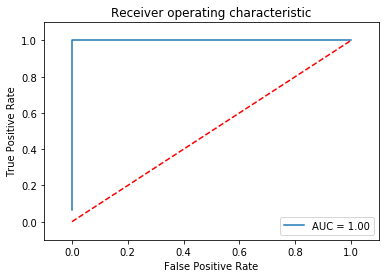

In [23]:
# ROC and AUC
from sklearn.metrics import roc_curve, auc

# Get predicted scores Pr(y=1): Used as thresholds for calculating TP Rate and FP Rate
# lr.classes_
score = lr.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, score) # fpr: FP Rate, tpr: TP Rate, thresholds: Pr(y=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

More about Logistic Regression can be found at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## 6 Assignments

### Using K-Fold Cross Validation to Do Model Evaluation

#### K-Fold Cross Validation:

<img src='http://www.scielo.br/img/revistas/jmoea/v16n3//2179-1074-jmoea-16-03-0628-gf04.jpg' width='500'>

K-Fold cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import datasets

Let's use a standard binary classification dataset from the UCI machine learning repository "Haberman's Survival Data Set" (https://archive.ics.uci.edu/ml/datasets/Haberman's+Survival). The dataset has one binary output and three numeric input variables of varying scales. The details about the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Haberman's+Survival).

In [25]:
# Load dataset: 
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"
names = ['age', 'year_operation', 'positive_detected', 'survive']
dataframe = pd.read_csv(url, names=names)
dataframe['survive'] = dataframe['survive'].map(lambda x:1 if x==1 else 0)  # =1, survive after 5 years; =0, die within 5 years

In [26]:
# Descriptive analysis
dataframe.describe()

,age,year_operation,positive_detected,survive
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,0.735294
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,0.000000
25%,44.000000,60.000000,0.000000,0.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,1.000000
max,83.000000,69.000000,52.000000,1.000000


In [27]:
# Features and output
features = ['age', 'year_operation', 'positive_detected']
output = 'survive'

#### Step 1. Do K-fold Cross Validation
* Set `n_splits=5`: 5-fold cross validation
* Set `random_state` to `12345`

Hint: Use `KFold` function

In [28]:
# Create a 5-fold cross validation
kf = KFold(n_splits = 5, random_state = 12345)
kf

KFold(n_splits=5, random_state=12345, shuffle=False)

#### Step 2. Create Multiple Models

* Model 1: Logistic regression with L2 regularization
* Model 2: Logistic regression with L1 regularization (Let's use the same parameter values as Model 1, except `penalty`)

In [29]:
# Model 1: Logistic regression with L2 regularization
model_1 = LogisticRegression(fit_intercept=True, max_iter=1000, tol=2e-9, penalty='l2', C=100, random_state=12345)

In [30]:
# Model 2: Logistic regression with L1 regularization (Let's use the same parameter values as Model 1, except penalty)
model_2 = LogisticRegression(fit_intercept=True, max_iter=1000, tol=2e-9, penalty='l1', C=100, random_state=12345)

#### Step 3. Conduct K-fold Cross-Validation on These Models

Hint: Use `cross_val_score` function

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [31]:
# Cross-validation on Model 1
cv_model_1 = cross_val_score(model_1, # Cross-validation on model_1
                             dataframe[features], # Feature matrix
                             dataframe[output], # Output vector
                             cv=kf, # Cross-validation technique
                             scoring='accuracy' # Model performance metrics: accuracy
                            )

In [32]:
# Cross-validation on Model 2
cv_model_2 = cross_val_score(model_2,
                             dataframe[features],
                             dataframe[output],
                             cv=kf,
                             scoring='accuracy'
                            )

#### Step 4. Report and Evaluate Mean Accuracy of These Models

<img src='https://cdn-images-1.medium.com/max/1600/1*J2B_bcbd1-s1kpWOu_FZrg.png' width='700'>

In [33]:
# Report average cross-validation accuracy of Model 1
print("CV Accuracies of Model 1: ", cv_model_1)
print("Average CV Accuracy of Model 1: ", np.average(cv_model_1))

# Report average cross-validation accuracy of Model 2
print("CV Accuracies of Model 2: ", cv_model_2)
print("Average CV Accuracy of Model 2: ", np.average(cv_model_2))


CV Accuracies of Model 1:  [0.80645161 0.67213115 0.67213115 0.7704918  0.73770492]
Average CV Accuracy of Model 1:  0.7317821258593337
CV Accuracies of Model 2:  [0.80645161 0.67213115 0.67213115 0.7704918  0.75409836]
Average CV Accuracy of Model 2:  0.7350608143839238


#### Step 5. Based on the cross-validation accuacy, which model do your prefer ?

## 7 References

[1] Jason Brownlee, 2018, [Machine Learning Algorithms from Scratch with Python](https://machinelearningmastery.com/machine-learning-algorithms-from-scratch/). <br/>
[2] Peter Harrington, 2012. Machine Learning in Action. Shelter Island, NY: Manning Publications Co.